# Deep Learning Bootcamp

## To edit this notebook, go to File -> Save a copy in Drive

Google Colab is a freemium cloud service based on Jupyter notebooks. It provides a virtual machine (VM) in which a Jupyter notebook can be executed, even with hardware acceleration like GPUs. The whole process is similar to Google borrowing us one of its computers. We can access this borrowed computer through this browser window.



## What is a Jupyter Notebook?


A Jupyter Notebook is a basically a nice looking web interface for the interactive Python interpreter. Interactive coding differs from classical coding. Instead of executing the whole program at once, you can execute small code cells in a sequential way. You can think of Jupyter Notebook as a chalk board. With each code cell, we we write something onto the chalk board. As long as we don't restart Notebook (=wiping the chalk board), we keep the changes made to our Notebook. This especially means that we don't have to execute previous code cells again and again if we make changes in subsequent cells. This also means that we have to execute previous code cells again (=overwriting the text written onto the chalk board) if we made changes to them.

Jupyter Notebooks also allow text cells. With the text cells, we can create interactive code stories in which you can play around and experiment with the theory provided in the text cell. There even exist whole books written as Jupyter Notebooks!



In [1]:
a = 10
b = 25

In [2]:
product = a * b
sum = a + b
result = product * sum
print(result)

8750


We sometimes need to distinguish whether we're using Colab or not, so let's check that.

In [3]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")

Not running in Google Colab


## GPU Runtimes

In order to use a GPU in our VM, we have to allocate a GPU runtime. You can do this in the menu bar -> Runtime -> Change runtime type -> Hardware accelerator -> GPU

To check if we really have a GPU and what type it is, we can use the linux commang 'nvidia-smi'. Nvidia SMI is a monitoring tool for Nvidia GPUs.

In [4]:
if IN_COLAB:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

Fri Jan  9 21:36:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   32C    P8             19W /   40W |     779MiB /  16303MiB |     27%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data Loading

A virtual machine is the simultion of a computer operating system (e.g. Windows or Linux) on another computer. Basically, it allows you to run an OS inside another OS. Mac Users may know this from Parallels Desktop, which allows to use Windows inside of Mac OS. Because a VM acts as another computer (that is trapped inside another computer), we have download our dataset inside this virtual computer system. We can again do this using linux commands. **You don't have to understand the following code, it's enough to understand that you can operate a computer entirely using a command line, which includes downloading and unzipping zip-files.**

In [5]:
fau_box_link = "https://faubox.rrze.uni-erlangen.de/dl/fiTCnufF4PbtbTwA7uUMsQ/traffic_sign.zip"

In [6]:
import time
import numpy as np
import os
import PIL
# PIL to show traffic sign images
from PIL import Image

# pathlib for path operations
from pathlib import Path
#  pandas is needed to process the csv files in the train and test folder of traffic_sign.zip
import pandas

# sklearn helps us with calculating confusion matrces
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# pyplot for plotting 
import matplotlib.pyplot as plt


if IN_COLAB:
    print("Installing p7zip-full...")
    ! apt install p7zip-full

if not os.path.exists('traffic_sign.zip'):
    print("Uploading data to Colab...")
    
    start_time = time.time()
    !wget {fau_box_link} -O 'traffic_sign.zip' # Here we download our zip file
    exec_time = time.time() - start_time
    print(f"Time to Upload: {round(exec_time, 2)} sec")

    !ls # We can take a look at our local directories with this command
    print("Unpacking...")
    start_time = time.time()
    
    # Here we unpack the donwloaded file into a local folder
    !7z x traffic_sign.zip  
    exec_time = time.time() - start_time
    print(f"Time to Unpack: {round(exec_time, 2)} sec")

    !ls

In [7]:
#### Config ####
image_size = 45
num_classes = 43
#################

## A small data pipeline

Our idea: we want to map paths of singke images from the *.csv file to transformed images.

### Converting a single path to a loaded image

Our first functions simply loads a single file path and resizes it. For loading the images, we use the Image module from PIL, a package for handling images. Because all images need to have the same size, we use PIL again to resize the loaded image to a prevoiously defined size. For our late use, we want to have the images in a numpy format, therefore we transform our image into a numpy image.

### Loading all files from a csv file

In order to read all files from our *.csv files, we have to load them in our prorgram first. To load a *.csv file, we use pandas, a package specifically designed for tabular data. We exract the column containing the labels first. Then we create a one-hot encoding for them to match the logits structure of our neural networks. Now we can start creating the huge matrix containing all loaded and resized images. First, we extract the column containing the image paths. Then we iterate over all paths and apply our conversion function to every single path. Now that we are done loding our data, we can return the images and labels.


In [8]:
def convert_path_to_image(path : Path, image_size=image_size):
    """ converts a path to a numpy image array and resizes it to a specified fixed size """
    temp = Image.open(path)
    img = temp.copy()
    temp.close()

    img = img.resize((image_size, image_size))
    return np.array(img)

def load_meta(meta_path: Path):
    """
    Load metadata from a CSV file.
    
    This method reads a CSV file containing class IDs and their corresponding
    labels, and returns them as numpy arrays.
    
    Args:
        meta_path: Path to the CSV file containing metadata
    """
    label_depictions = []
    for i in range(num_classes):
        p = Path(meta_path) / f"{i}.png"
        if p.exists():
            try:
                label_depictions.append(convert_path_to_image(p))
            except Exception:
                label_depictions.append(np.zeros((image_size, image_size, 3), dtype=np.uint8))
        else:
            label_depictions.append(np.zeros((image_size, image_size, 3), dtype=np.uint8))
    
    return label_depictions

def load_csv(csv_path: Path, root_path: Path):
    """
    Load images from a CSV file and convert them to numpy arrays.
    
    This method reads a CSV file containing image paths and class labels,
    loads the images from the specified directory, and converts them into
    numpy arrays with one-hot encoded labels.
    
    Args:
        csv_path: Path to the CSV file containing image paths and class IDs
        root_path: Root directory path where the images are stored
        
    Returns:
        tuple: A tuple containing:
            - images: numpy array of shape (n_samples, image_size, image_size, 3)
            - labels: numpy array of one-hot encoded labels of shape (n_samples, num_classes)
    """
    data_frame = pandas.read_csv(csv_path)

    label_ints = data_frame.pop('ClassId').to_numpy()
    labels = np.zeros((label_ints.size, label_ints.max()+1)) # one hot encoding. Here we do the shape
    labels[np.arange(label_ints.size), label_ints] = 1       # arange: list of all x indices, label ints contains all indeces in y -> we want to set all these to 1

    img_paths = data_frame.pop('Path').to_numpy()
    images = np.array([convert_path_to_image(root_path / p) for p in img_paths])

    return images, labels

def plot_image(images: list, labels: list, label_depictions: list, index:int):
    """Plot a single image with its label."""
    print(f"Label: {np.argmax(labels[index])}")
    print(f"One hot label: {labels[index]}")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(images[index])
    ax1.set_title(f"Image (Label: {np.argmax(labels[index])})")
    ax1.axis('off')
    ax2.imshow(label_depictions[np.argmax(labels[index])])
    ax2.set_title("Label Depiction")
    ax2.axis('off')

    plt.show()

def plot_images(images, labels, label_depictions, n=3):
    indices = np.random.randint(len(images), size=n)

    for i in indices:
        plot_image(images, labels, label_depictions, i)

def plot_label(label_depictions, index):
    plt.imshow(label_depictions[index])
    plt.show()

(39209, 45, 45, 3)
(39209, 43)
(12630, 45, 45, 3)
(12630, 43)
Label: 1
One hot label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


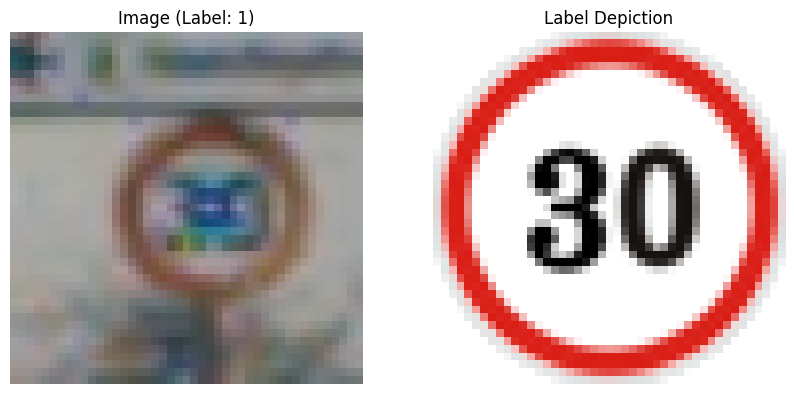

Label: 10
One hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


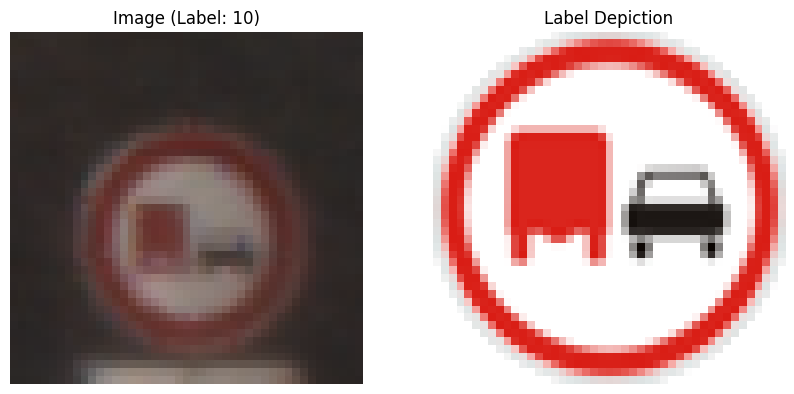

Label: 38
One hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


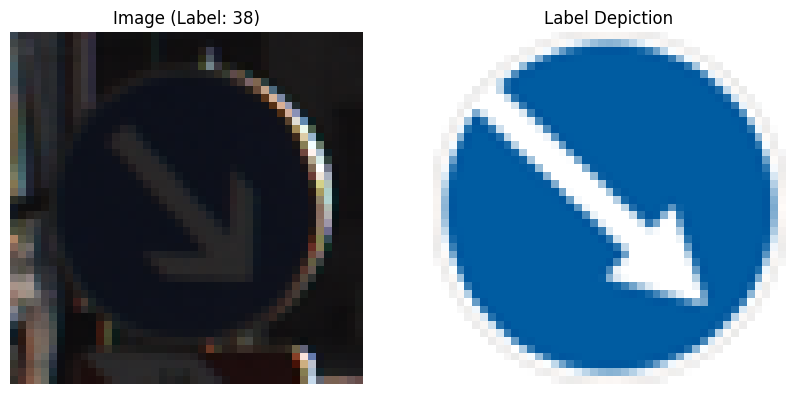

In [9]:
"""
Method from https://www.tensorflow.org/tutorials/load_data/images
"""

data_root_path = Path('./traffic_sign')
train_path = data_root_path / 'Train.csv'
test_path = data_root_path / 'Test.csv'
meta_path = data_root_path / 'Meta'

train_images, train_labels = load_csv(train_path, data_root_path)
label_depictions = load_meta(meta_path)
print(train_images.shape)
print(train_labels.shape)

test_images, test_labels = load_csv(test_path, data_root_path)
print(test_images.shape)
print(test_labels.shape)

plot_images(train_images, train_labels, label_depictions)

# Our data set as a Pytorch DataLoader
## A basic data loader

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

batch_size = 64

class TrafficSignDataset(Dataset):
    def __init__(self, images, labels):
        # Convert numpy arrays to torch tensors
        # Transpose from (N, H, W, C) to (N, C, H, W) for PyTorch
        # Normalize images to [0, 1]
        self.images = torch.from_numpy(images).float().permute(0, 3, 1, 2) / 255.0
        self.labels = torch.from_numpy(labels).float()
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create full training dataset
full_train_dataset = TrafficSignDataset(train_images, train_labels)

# Split into train (70%) and validation (30%)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create test dataset
test_dataset = TrafficSignDataset(test_images, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of train batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Train dataset size: 27446
Validation dataset size: 11763
Test dataset size: 12630
Number of train batches: 429
Number of validation batches: 184
Number of test batches: 198


## Our models

### Fully connected network

This is the most simple network. We start with flattening our inputs. Then we gradually decrease the dimensionality of the internal feature vector. Our last layer has num_classes neurons because we want create a one-hot encoding of our outputs.

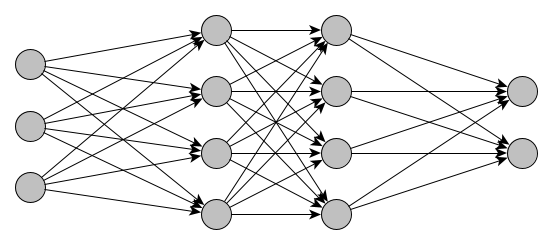

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleFullyConnectedNet(nn.Module):
    def __init__(self, input_dim=image_size*image_size*3, hidden_dim=128, num_classes=num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # Flatten the input (batch_size, 3, 45, 45) -> (batch_size, 3*45*45)
        x = torch.flatten(x, start_dim=1)
        
        # First hidden layer with ReLU
        x = F.relu(self.fc1(x))
        
        # Second hidden layer with ReLU
        x = F.relu(self.fc2(x))
        
        # Output layer (no activation, will use CrossEntropyLoss)
        x = self.fc3(x)
        
        return x

# Create the model
simple_fc = SimpleFullyConnectedNet()
print(simple_fc)

SimpleFullyConnectedNet(
  (fc1): Linear(in_features=6075, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=43, bias=True)
)


# A Model Trainer

With our model trainer, we will implement the main loop needed in Pytorch

In [29]:
import torch

import torch.optim as optim
import torch.nn as nn

def train(model, learning_rate=0.001, num_epochs=100):
    """
    Train a PyTorch model on the traffic sign dataset.
    
    Args:
        model: PyTorch model to train
        learning_rate: Learning rate for the optimizer
        num_epochs: Number of training epochs
        
    Returns:
        history: Dictionary containing training and validation metrics
    """
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move model to device
    model.to(device)
    
    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Convert one-hot labels to class indices
            labels = torch.argmax(labels, dim=1)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                labels = torch.argmax(labels, dim=1)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate validation metrics
        val_loss = val_running_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Store metrics in history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print metrics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    print('Finished Training')
    return history

# Train the model and get history
history = train(simple_fc, learning_rate=0.001, num_epochs=100)

Using device: cuda
Epoch [1/100], Train Loss: 2.0692, Train Acc: 44.83%, Val Loss: 1.2477, Val Acc: 65.93%
Epoch [2/100], Train Loss: 0.9202, Train Acc: 75.14%, Val Loss: 0.7080, Val Acc: 81.07%
Epoch [3/100], Train Loss: 0.6344, Train Acc: 82.90%, Val Loss: 0.6558, Val Acc: 81.97%
Epoch [4/100], Train Loss: 0.5098, Train Acc: 86.64%, Val Loss: 0.6867, Val Acc: 81.90%
Epoch [5/100], Train Loss: 0.4398, Train Acc: 88.41%, Val Loss: 0.4913, Val Acc: 85.80%
Epoch [6/100], Train Loss: 0.3876, Train Acc: 89.72%, Val Loss: 0.4131, Val Acc: 89.38%
Epoch [7/100], Train Loss: 0.3629, Train Acc: 90.46%, Val Loss: 0.3743, Val Acc: 90.05%
Epoch [8/100], Train Loss: 0.3030, Train Acc: 92.19%, Val Loss: 0.3577, Val Acc: 89.96%
Epoch [9/100], Train Loss: 0.2853, Train Acc: 92.35%, Val Loss: 0.4088, Val Acc: 88.70%
Epoch [10/100], Train Loss: 0.2677, Train Acc: 92.68%, Val Loss: 0.3814, Val Acc: 89.91%
Epoch [11/100], Train Loss: 0.2688, Train Acc: 92.73%, Val Loss: 0.3738, Val Acc: 90.34%
Epoch [12/1

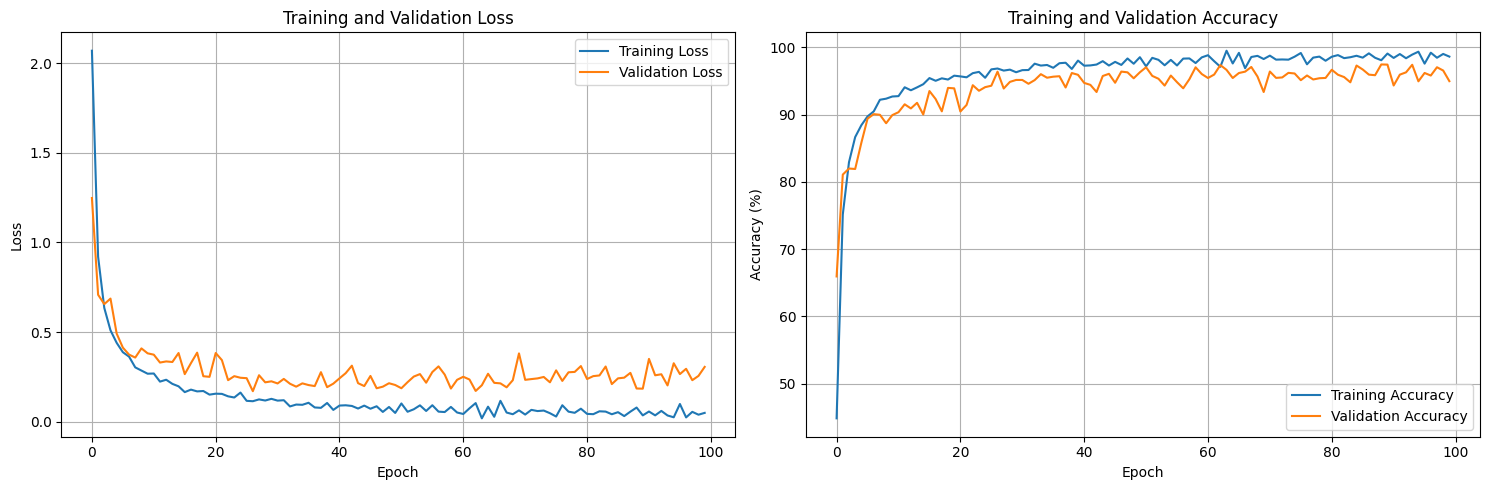

In [30]:
import matplotlib.pyplot as plt

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss
ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot training and validation accuracy
ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Small Convolutional Network

The small convolutional network aims to solve the problems occuring with fully connected networks. This network is split in two parts: feature extraction using convolutional layers and the decision part using fully connected layers. In the feature extraction part, we use two convolutional layers two extract a 16 channel deep feature map. The we flatten this layer and let 3 fully connected layers learn to classify the extracted features.

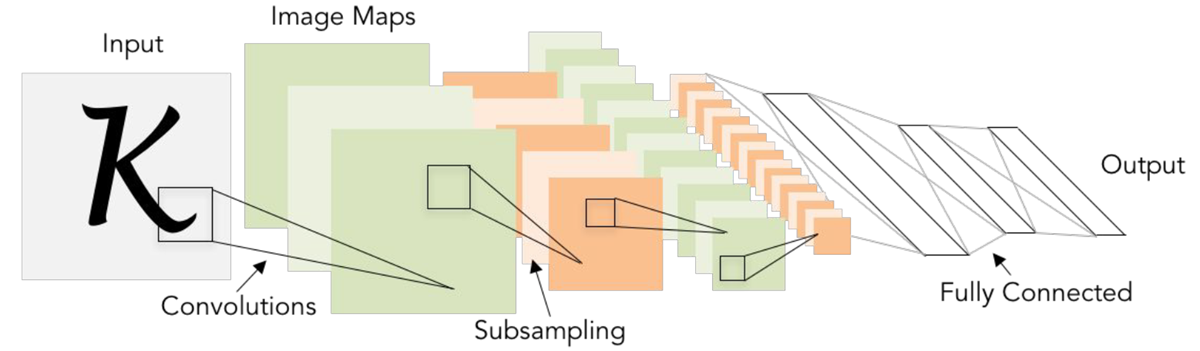

In [12]:
def small_conv_net(num_classes=num_classes):
    model = keras.Sequential([
        keras.Input(shape = (image_size, image_size, 3)),
        layers.Conv2D(filters = 6, kernel_size=(3,3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(120, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model


In [13]:
def medium_conv_net(num_classes=num_classes):
    model = keras.Sequential([
        keras.Input(shape = (image_size, image_size, 3)),
        layers.Conv2D(filters = 6, kernel_size=(3,3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(filters = 10, kernel_size=(3,3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(120, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

In [14]:
def large_conv_net(num_classes=num_classes):
    pass

### Using a pretrained model

This would be the go-to-approach in real life. For this example, we use ResNet-50 v2. In order to use the model, we have to change the input dimensions of the model. Then again we can classify the extracted features.

In [15]:
def pretrained_model(num_classes=num_classes):
    base_model = keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=(image_size, image_size, 3)
    )
    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model


## Training our model

Keras hides most of the work necessary for training neural networks. But we still have to define some parts. First, we instantiate our model. Then we define the training algorithms that optimizes our parameters and the loss functions that should be minimized. Now we can compile the model. You can see this as glueing together the components for the training. Here we also tell keras that we want to use the accuracy metric for evaluation. Finally, we can call the .fit method with our dataset as parameter. The .fit methods trains our networks by iterating num_epoch times over the dataset, that is split in small batch_size large pieces.

In [16]:
#train the model

#model = fully_connected_net()
#model = small_conv_net()
#model = medium_conv_net()
model = pretrained_model()
model.summary()

NameError: name 'keras' is not defined

In [ ]:
#### Config ####
batch_size = 64
num_epochs = 7
learning_rate = 0.0001
#################

In [ ]:
opt = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=num_epochs, batch_size=batch_size,  validation_data=(test_images, test_labels))

Epoch 1/7
613/613 ━━━━━━━━━━━━━━━━━━━━ 102s 98ms/step - accuracy: 0.5455 - loss: 1.7789 - val_accuracy: 0.8442 - val_loss: 0.5422
Epoch 2/7
613/613 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.9831 - loss: 0.0580 - val_accuracy: 0.8888 - val_loss: 0.4117
Epoch 3/7
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9939 - loss: 0.0215 - val_accuracy: 0.8944 - val_loss: 0.4552
Epoch 4/7
613/613 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.9932 - loss: 0.0236 - val_accuracy: 0.8956 - val_loss: 0.4589
Epoch 5/7
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9928 - loss: 0.0257 - val_accuracy: 0.9321 - val_loss: 0.2862
Epoch 6/7
613/613 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.9947 - loss: 0.0192 - val_accuracy: 0.9242 - val_loss: 0.3427
Epoch 7/7
613/613 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.9963 - loss: 0.0138 - val_accuracy: 0.9483 - val_loss: 0.2484


## Evaluating our model

Since we finished training our model, we want to know its ability to generalize. Therefore, we load our test dataset with unseen instances and pass it to the .evaluate function. To get a better understanding about our model's abilieties, we want so visualize its predictions on the unseen test dataset in a confusion matrix. To calculate the confusion matrix, we use scikit-learn (short: sklearn), which is an excellent framework for classical machine learning. To plot the confusion matrix, we use the built-in functions of sklearn.

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8604 - loss: 1.1452
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


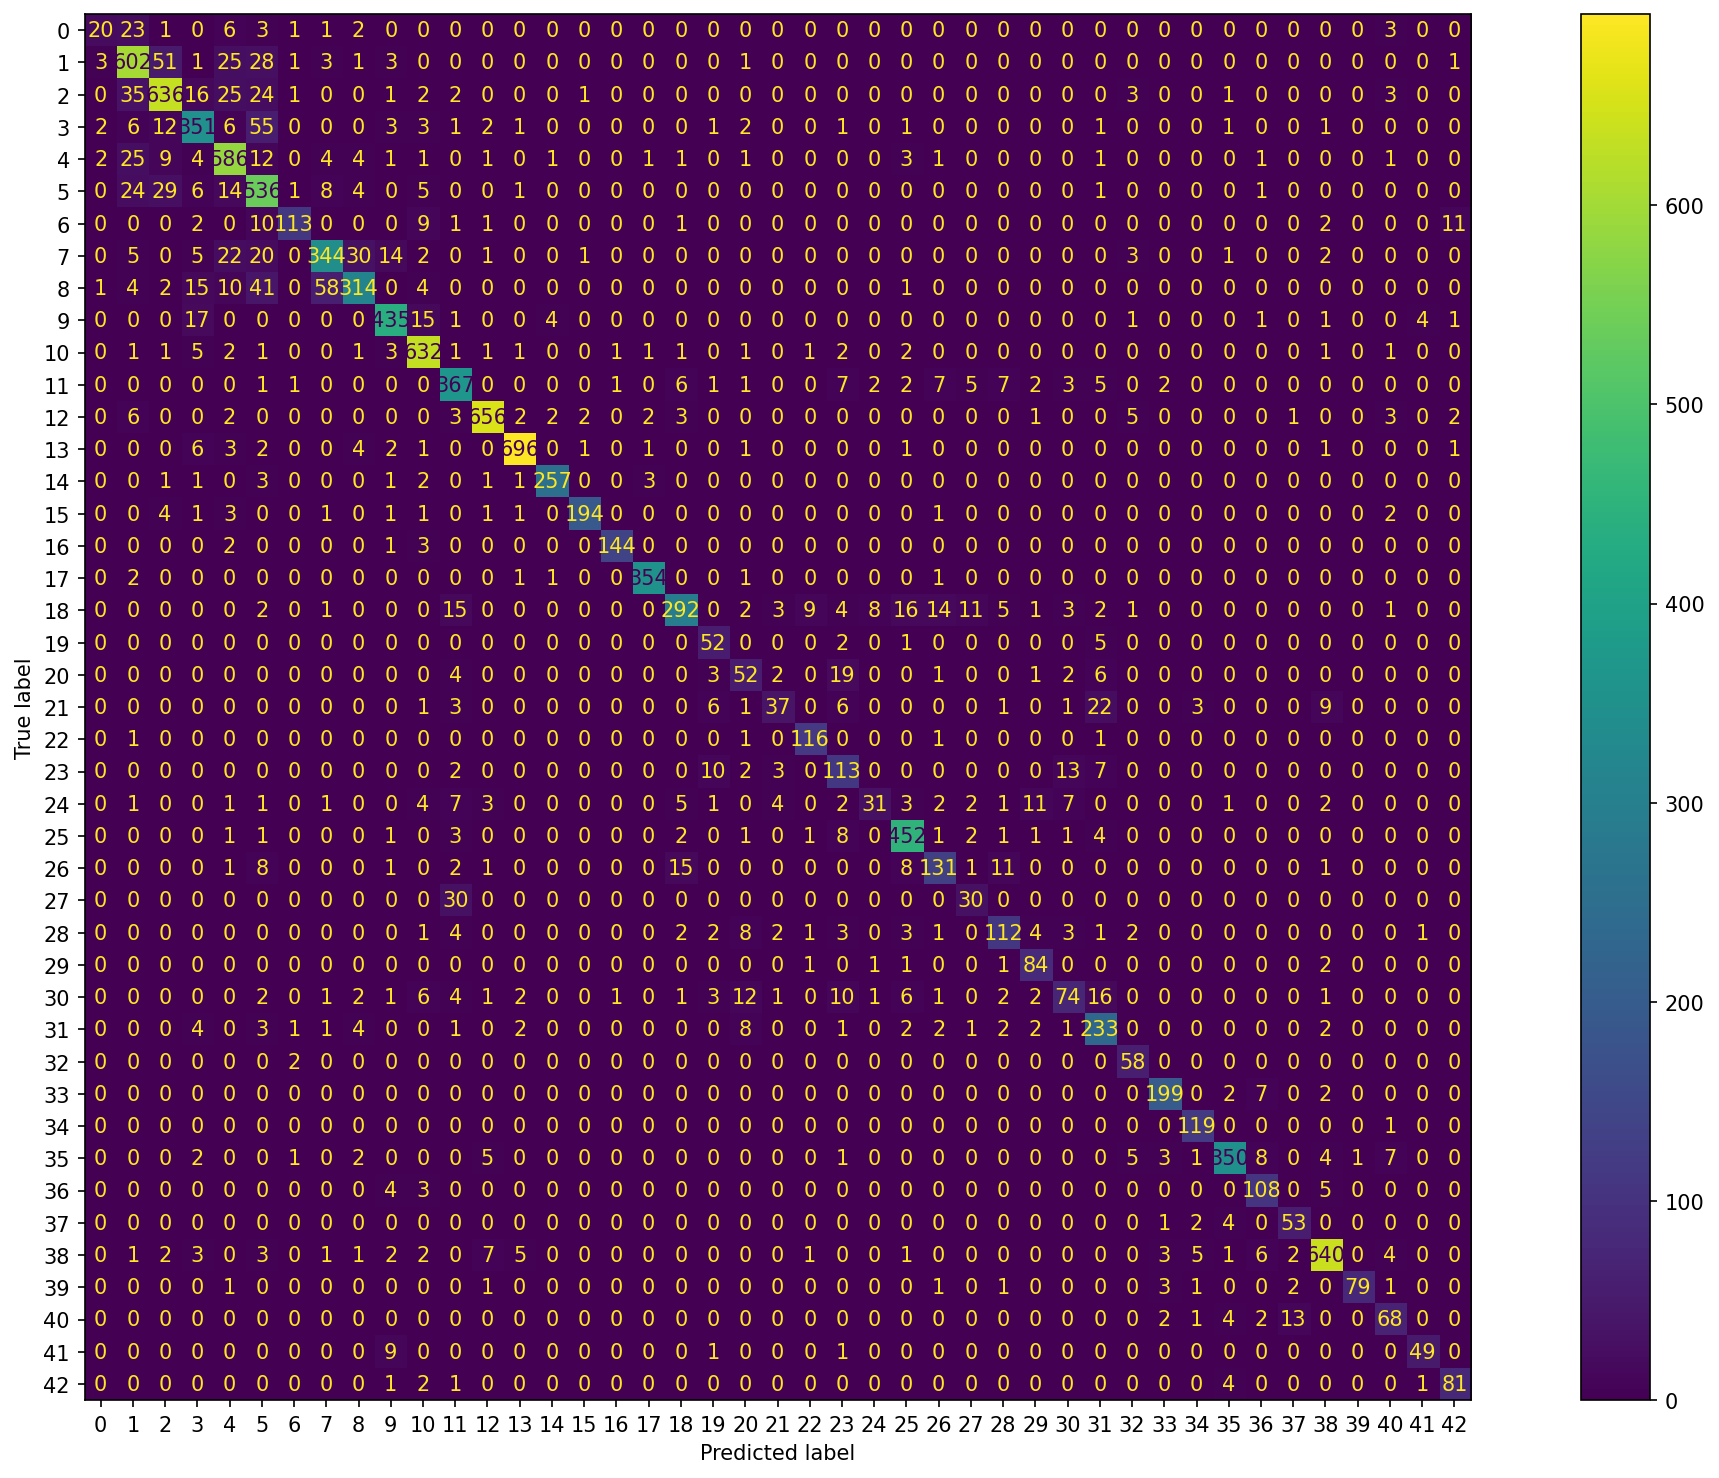

In [ ]:
model.evaluate(test_images, test_labels)

predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predictions)

# just for better presentation - but store original values
default_figsize = plt.rcParams['figure.figsize']
default_dpi = plt.rcParams['figure.dpi']

plt.rcParams['figure.figsize'] = [19, 12]
plt.rcParams['figure.dpi'] = 150

display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(43))
display.plot(values_format='-')
plt.show()

# set back to original values
plt.rcParams['figure.figsize'] = default_figsize
plt.rcParams['figure.dpi'] = default_dpi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
(45, 45, 3)
Prediction
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[17]
Label
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
17


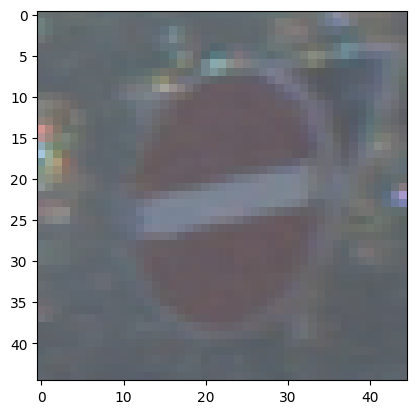

In [ ]:
image_index = 2547
prediction=model.predict(test_images[image_index].reshape(1,45,45,3))
image = test_images[image_index]
label = test_labels[image_index]

plt.imshow(image)
print(image.shape)
print("Prediction")
print(np.round(prediction, 3))
print(np.argmax(prediction, axis=1))
print("Label")
print(np.round(label, 4))
print(np.argmax(label))